In [220]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.utils.data.dataset as dataset
import numpy as np
from osgeo import gdal
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

from dataset import load_file
from model import *

In [221]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [222]:
IMG_FOLDER = 'E:/xplore_data/data/'

## Extract features

In [223]:
# Load trained model
net = initialize_model2()
n_features = 512

SAVED_MODEL_PATH = 'checkpoints/vgg11bn_2_4'
net.load_state_dict(torch.load(SAVED_MODEL_PATH))

# Freeze layers
for param in net.parameters():
    param.requires_grad = False
    
# We just want to apply the feature extractor for now
net.classifier = nn.Identity()

In [224]:
# Get dataset
DATA_FILE = 'E:/xplore_data/data/images.h5'
HEALTH_FILE = 'data/dhs_gps.csv'
dimages = TestDataset(DATA_FILE, HEALTH_FILE)
dimagesloader = torch.utils.data.DataLoader(dimages, batch_size=64, shuffle=False, num_workers=0)

In [225]:
# Apply feature extractor to the dataset
n = len(dimages)
extracted_features = torch.zeros(n, n_features)
c_ids = np.zeros(n)
i = 0
# Iterate over data.
net.to(device)
for x, _, z in dimagesloader:
    x = x.to(device)
    j = i + x.shape[0]
    with torch.set_grad_enabled(False):
        outputs = net(x)
        extracted_features[i:j, :] = torch.squeeze(outputs).cpu()
        c_ids[i:j] = z[:, 0]
    i += 64
extracted_features = extracted_features.numpy()
c_ids = c_ids.astype(np.int)

## Compute t-SNE embedding of features

In [226]:
tsne = TSNE(n_components=2, perplexity=25)
embed = tsne.fit_transform(extracted_features)

In [227]:
embed = embed - embed.min()
embed = embed / embed.max()

In [228]:
import matplotlib.pyplot as plt

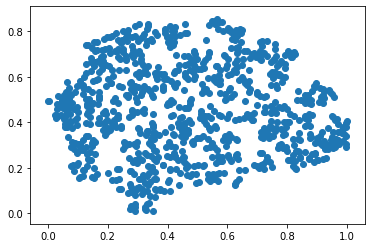

In [229]:
plt.scatter(embed[:,0], embed[:,1])

## Create big image

In [230]:
m = 25
n = extracted_features.shape[0]
g_start = (1/m)/2
g_step = 1/m

In [237]:
# Loop over all positions to find closest
c_id_grid = np.zeros((m, m), np.int)
used = np.zeros(n).astype(np.bool)
for k in range(m*m):
    i = k // m
    j = k % m
    center = np.array([g_start+i*g_step, g_start+j*g_step])
    sq_dists = np.sum((embed-center)**2, 1)
    sq_dists[used] = np.inf
    idx_closest = np.argmin(sq_dists)
    # Don't do anything if the closest is too far away
    if sq_dists[idx_closest] > 2*g_step**2:
        c_id_grid[i,j] = -1
    else:
        used[idx_closest] = True
        c_id_grid[i,j] = c_ids[idx_closest]
    

In [238]:
# Create big grid and fill it in
t = 100
vis_grid = np.zeros((m*t, m*t, 3), np.uint8)
ir_grid = np.zeros((m*t, m*t, 3), np.uint8)
print('cluster_id, i, j')
for k in range(m*m):
    i = k // m
    j = k % m
    x0 = i*t
    y0 = j*t
    c = c_id_grid[i,j]
    if not c == -1:
        print('%d, %d, %d' % (c, i, j))
        # Load image
        img = load_file(IMG_FOLDER, 'image_' + str(c).rjust(3, '0') + '.tif')
        # Center crop it
        hstart = (img.shape[1]-333)//2
        wstart = (img.shape[2]-333)//2
        img = img[:, hstart:(hstart+333), wstart:wstart+333]
        # Resize it
        img = F.interpolate(img[None,:,:,:], size=[t,t], mode='bilinear')
        img = img.squeeze().permute((1, 2, 0))
        # Put it in the grid
        vis_grid[x0:x0+t, y0:y0+t, :] = img[:,:,[3,2,1]].numpy()
        ir_grid[x0:x0+t, y0:y0+t, :] = img[:,:,[6,4,0]].numpy()
    
    

cluster_id, i, j
866, 0, 8
658, 0, 9


E:\Anaconda\envs\xplore\lib\site-packages\torch\nn\functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


834, 0, 10
719, 0, 11
828, 0, 12
767, 0, 13
721, 0, 14
841, 1, 3
842, 1, 4
663, 1, 5
133, 1, 6
495, 1, 7
863, 1, 8
659, 1, 9
717, 1, 10
751, 1, 11
749, 1, 12
754, 1, 13
763, 1, 14
844, 2, 3
14, 2, 4
19, 2, 5
117, 2, 6
493, 2, 7
718, 2, 8
179, 2, 9
827, 2, 10
2, 2, 11
735, 2, 12
709, 2, 13
572, 2, 14
282, 2, 15
580, 2, 16
330, 2, 17
480, 2, 18
479, 2, 19
51, 3, 3
144, 3, 4
586, 3, 5
501, 3, 6
143, 3, 7
3, 3, 8
72, 3, 9
268, 3, 10
345, 3, 11
178, 3, 12
812, 3, 13
351, 3, 14
434, 3, 15
433, 3, 16
134, 3, 17
478, 3, 18
477, 3, 19
851, 4, 3
116, 4, 4
504, 4, 5
849, 4, 6
161, 4, 7
142, 4, 8
54, 4, 9
138, 4, 10
205, 4, 11
249, 4, 12
429, 4, 13
833, 4, 14
387, 4, 15
131, 4, 16
313, 4, 17
42, 4, 18
897, 4, 19
896, 4, 20
262, 5, 0
50, 5, 1
15, 5, 2
21, 5, 3
58, 5, 4
52, 5, 5
153, 5, 6
266, 5, 7
257, 5, 8
565, 5, 9
46, 5, 10
236, 5, 11
662, 5, 12
605, 5, 13
738, 5, 14
448, 5, 15
710, 5, 16
676, 5, 17
684, 5, 18
901, 5, 19
549, 5, 20
273, 6, 0
261, 6, 1
413, 6, 2
353, 6, 3
339, 6, 4
869, 6, 5
71, 

In [239]:
vis_img = vis_grid/255/np.array([.25, .2 ,.2])
vis_img = np.clip(vis_img, 0, 1)
ir_img = ir_grid/255/np.array([.6, .8 ,.25])
ir_img = np.clip(ir_img, 0, 1)

(-0.5, 2499.5, 2499.5, -0.5)

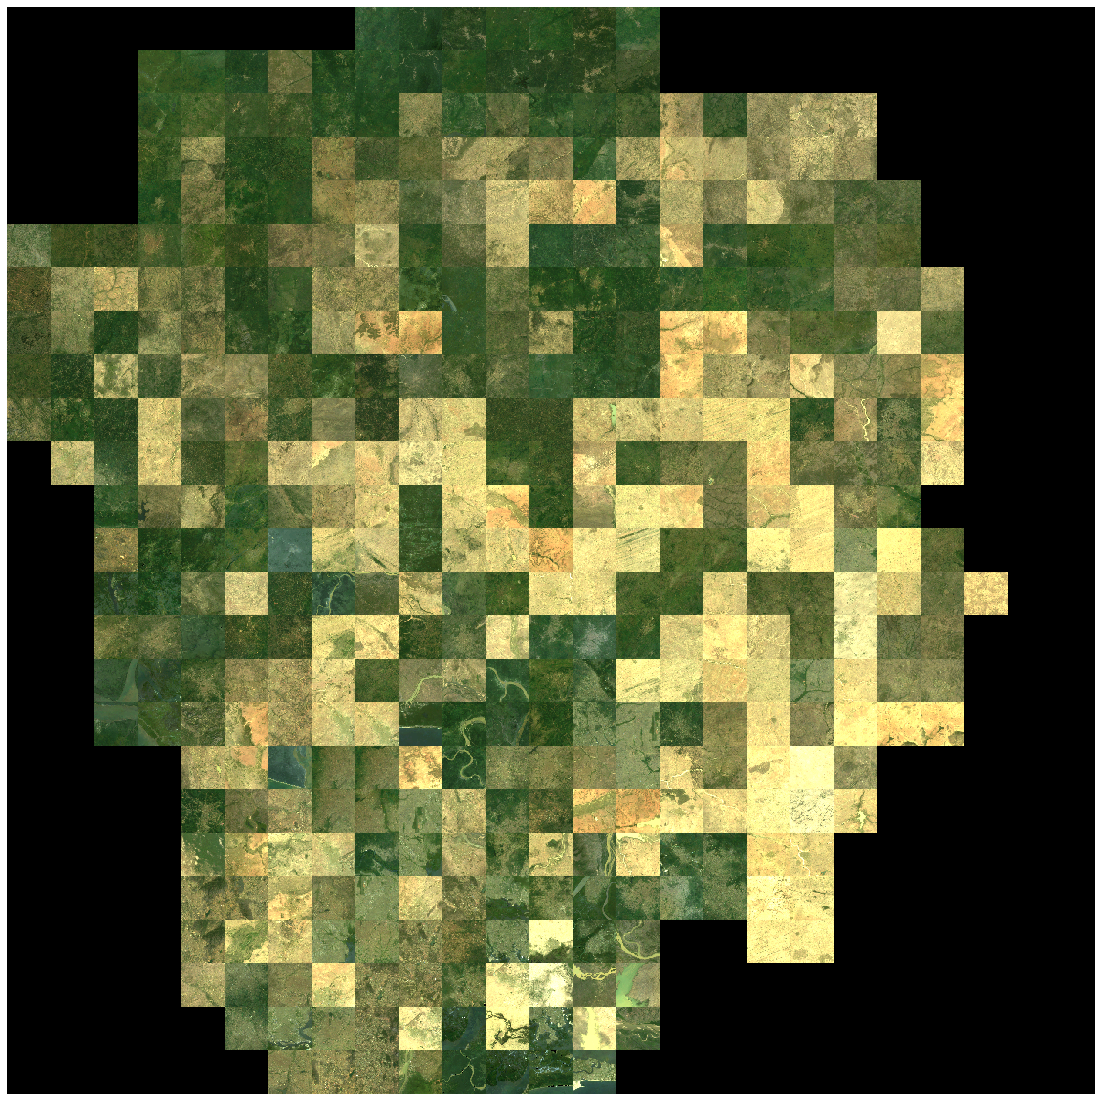

In [240]:
f, ax = plt.subplots(figsize=(20,20))
ax.imshow(vis_img)
ax.axis('off')

(-0.5, 2499.5, 2499.5, -0.5)

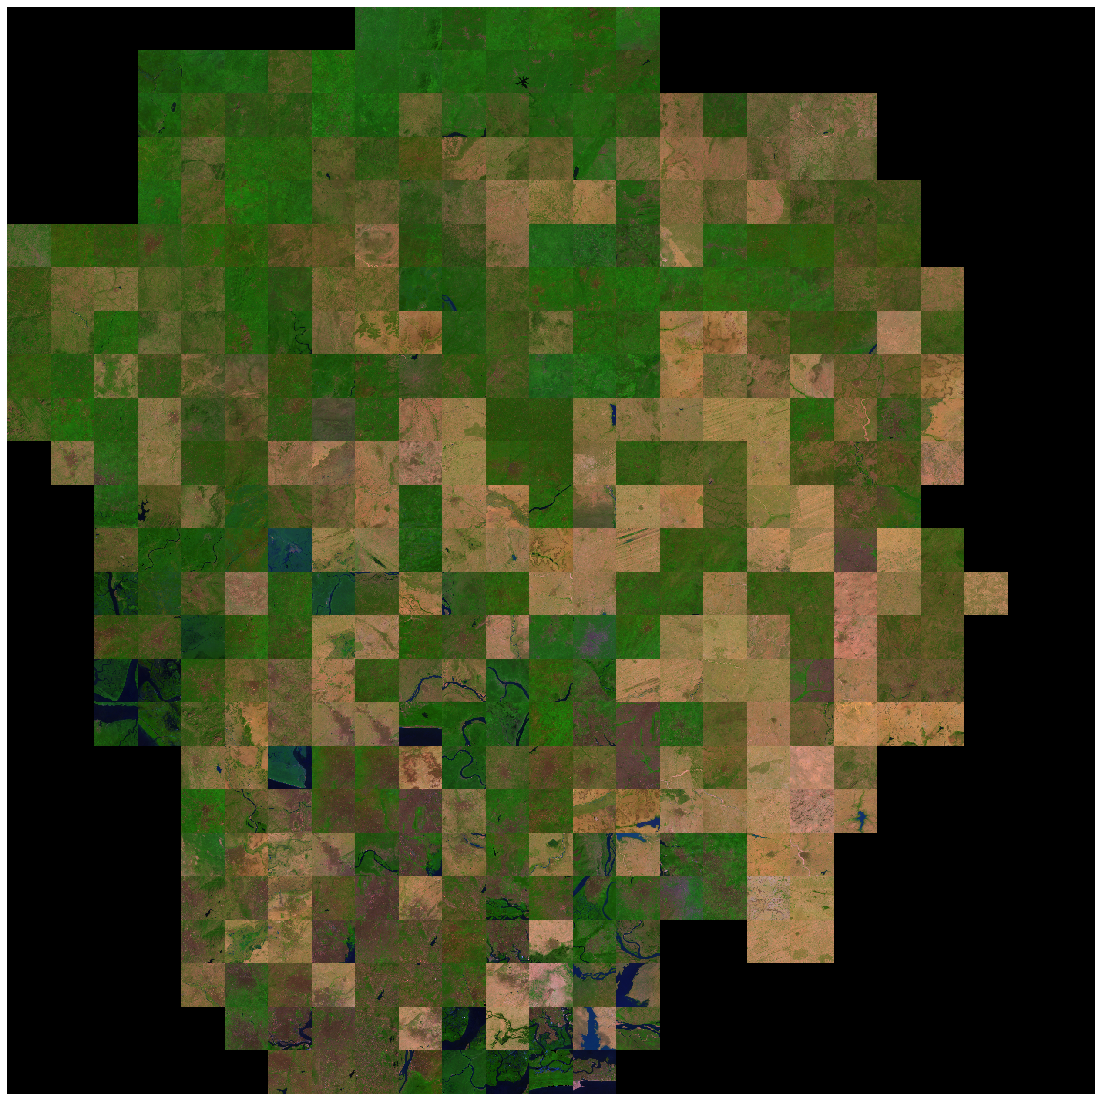

In [241]:
f, ax = plt.subplots(figsize=(20,20))
ax.imshow(ir_img)
ax.axis('off')

In [242]:
used.sum()

425